In [1]:
import sys
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

In [ ]:
s = ['A191RL']

df = nipa_df(retrieve_table('T10502')['Data'], s).sort_index()

df.to_csv(data_dir / 'gdp.csv', index_label='date')

txt = f'{df.index[-1].year} Q{df.index[-1].quarter}: {df["A191RL"].iloc[-1]}\%'

write_txt(data_dir / 'gdp.txt', txt)

In [19]:
# Private fixed investment
s = ['A008RY', 'A011RY', 'A014RY']

(nipa_df(retrieve_table('T10502')['Data'], s)
 .to_csv(data_dir / 'inv.csv', index_label='date'))

In [24]:
# Import and Export share of GDP
s = ['B020RC', 'B021RC', 'A191RC']

data = nipa_df(retrieve_table('T10105')['Data'], s)
((data.div(data['A191RC'], axis=0) * 100)
      .to_csv(data_dir / 'eximgdp.csv', index_label='date'))

#(nipa_df(retrieve_table('T10105')['Data'], s)
# .to_csv(data_dir / 'eximgdp.csv', index_label='date'))

In [ ]:
s = ['DPCERY', 'A006RY', 'A822RY', 'A019RY']

(nipa_df(retrieve_table('T10502')['Data'], s)
 .to_csv(data_dir / 'comp.csv', index_label='date'))

In [ ]:
s = ['A939RC', 'A939RX']

df = nipa_df(retrieve_table('T70100')['Data'], s)
df['value'] = (df['A939RX'] / df['A939RX'].iloc[-1])  * df['A939RC'].iloc[-1]
df[['value']].to_csv(data_dir / 'gdppc.csv', index_label='date')

In [ ]:
s = ['A261RX', 'W256RX']
rgdi = nipa_df(retrieve_table('T11706')['Data'], s).dropna()

s = ['A261RC', 'A4002C', 'W056RC', 'A107RC', 'W271RC', 'A262RC']
df = nipa_df(retrieve_table('T11000')['Data'], s).dropna()

# Calculate indirect taxes net of transfers
df['indirect'] = df['W056RC'] - df['A107RC']
df = df.drop(['A107RC', 'W056RC'], axis=1)

# Calculate GDI deflator from real GDI series
deflator = rgdi['A261RX'] / df['A261RC']
deflator = deflator / deflator.iloc[-1]
df = df.multiply(deflator, axis=0)

# Calculate contributions to growth
dft = df.diff()
dft = dft.div(dft['A261RC'], axis=0)
contr = dft.multiply((((df['A261RC'].pct_change() + 1) ** 4) - 1) * 100, axis=0)
contr.round(2).to_csv(data_dir / 'gdi.csv', index_label='date')

### Consumer Spending

In [ ]:
s = ['DGDSRY', 'DHCERY', 'DHUTRY', 'A011RY']

(nipa_df(retrieve_table('T10502')['Data'], s)
 .assign(OTHSER = lambda x: x['DHCERY'] - x['DHUTRY'],
         HOUSING = lambda x: x['A011RY'] + x['DHUTRY'])
 .drop('DHCERY', axis=1)
 .to_csv(data_dir / 'pce.csv', index_label='date'))

### Trade Contribution to GDP

In [ ]:
s = ['A019RY', 'A253RY', 'A646RY', 'A255RY', 'A656RY']
df = nipa_df(retrieve_table('T10502')['Data'], s)
df.to_csv(data_dir / 'nx.csv', index_label='date')

In [ ]:
sl = [('A253RY', 'main'), ('A646RY', 'end'), 
      ('A255RY', 'main'), ('A656RY', 'end')]

d = {}

for s, style in sl:
    # Latest total value
    value = df[s].iloc[-1]
    d[s] = cont_subt(value, style=style)

# Text for household expenditure section
q = {1: 'first', 2: 'second', 3: 'third', 4: 'fourth'}
    
ld2 = f'{q[df.index[-1].quarter]} quarter of {df.index[-1].year}'


text = f"Goods exports {d['A253RY']} GDP growth in the {ld2} while services exports {d['A646RY']}. Good imports {d['A255RY']} GDP growth and services imports {d['A656RY']}."
# Print to file
f = text_dir.joinpath('trade.txt')
with f.open('w') as text_file:
    text_file.write(text)

### Business investment

In [ ]:
s = ['Y001RY', 'A009RY', 'Y033RY']

In [ ]:
df = nipa_df(retrieve_table('T10502')['Data'], s)
df.to_csv(data_dir / 'businv.csv', index_label='date')

### Government spending and investment

In [ ]:
s = ['A824RY', 'A825RY', 'A829RY']

In [ ]:
df = nipa_df(retrieve_table('T10502')['Data'], s)
df.to_csv(data_dir / 'gov.csv', index_label='date')

### Personal Income

In [ ]:
s = ['DPCERG']

d = nipa_df(retrieve_table('T20304')['Data'], s)['DPCERG']
deflator = d.iloc[-1] / d

s = ['A065RC', 'A033RC', 'A041RC', 'A048RC', 'W210RC', 'A577RC', 'A061RC']

df = (nipa_df(retrieve_table('T20100')['Data'], s)
      .assign(CAPITAL = lambda x: x['A041RC'] + x['A048RC'] + x['W210RC'],
              TRANSFER = lambda x: x['A577RC'] - x['A061RC'])
      .drop(['A061RC', 'A041RC', 'A048RC', 'W210RC', 'A577RC'], axis=1)
      .multiply(deflator, axis=0))
growth_contrib(df, 'A065RC').to_csv(data_dir / 'pi.csv', index_label='date')

### Sectoral Accounts

In [ ]:
s = ['W162RC', 'W994RC', 'AD01RC']
df = (nipa_df(retrieve_table('T50100')['Data'], s).div(
      nipa_df(retrieve_table('T10105')['Data'], ['A191RC'])['A191RC'], axis=0)) * 100

data = pd.DataFrame()
data['PRIV'] = df['W994RC']
data['GOV'] = df['AD01RC']
data['ROW'] = -df['W162RC']
data = data.dropna()
date = f'{data.index[-1].year} Q{data.index[-1].quarter}'

In [ ]:
data.dropna().to_csv(data_dir / 'sectbal.csv', index_label='date')

In [ ]:
sectbaltxt = f"In {date}, the US private sector was a net lender (running a surplus) of the equivalent of {data['PRIV'].iloc[-1]:.1f} percent of GDP, compared to {data.loc['2015-01-01', 'PRIV']:.1f} percent in 2015 Q1. The rest of the world was a net lender to the US, to the equivalent of {data['ROW'].iloc[-1]:.1f} percent of GDP in {date} compared to {data.loc['2015-01-01', 'ROW']:.1f} percent in 2015 Q1. Balancing these transactions, the government (federal, state, and local combined) was a net borrower (running a deficit) of the equivalent of {data['GOV'].iloc[-1]:.1f} percent of GDP, compared to {data.loc['2015-01-01', 'GOV']:.1f} percent in 2015. "
print(sectbaltxt)

In [ ]:
# Print latest date to file
f = text_dir.joinpath('sectbal.txt')
with f.open('w') as wf:
    wf.write(sectbaltxt)

### Current Account Balance

In [ ]:
s = ['A191RC']

gdp = nipa_df(retrieve_table('T10105')['Data'], s)

s = ['A124RC', 'A253RC', 'A255RC', 'A646RC', 'B656RC', 'B645RC',
     'A655RC', 'A123RC']

df = (nipa_df(retrieve_table('T40100')['Data'], s)
      .assign(GOODS = lambda x: x['A253RC'] - x['A255RC'],
              SERVICES = lambda x: x['A646RC'] - x['B656RC'],
              INCOME = lambda x: x['B645RC'] - x['A655RC'],
              TRANSFERS = lambda x: - x['A123RC'])
      .drop(s[1:], axis=1).drop_duplicates())

data = (df.div(nipa_df(retrieve_table('T10105')['Data'], ['A191RC']
               )['A191RC'], axis=0).dropna().loc['1989':].multiply(100).round(2))

data.to_csv(data_dir / 'cab.csv', index_label='date')

In [ ]:
cab = abs(data['A124RC'].iloc[-1])
tb = abs(data['GOODS'].iloc[-1])
ld = f'{data.index[-1].year} Q{data.index[-1].quarter}'

text = f'As of {ld}, the US runs a current account deficit of {cab:.1f} percent of GDP, primarily as the result of a trade deficit on goods of {tb:.1f} percent of GDP.'

# Print latest date to file
f = text_dir.joinpath('cab.txt')
with f.open('w') as wf:
    wf.write(text)

### Wealth to GDP



In [ ]:
url = 'https://www.federalreserve.gov/datadownload/Output.aspx?rel=Z1&series=71f2e13e70c5d96bb5da3a65053d836e&lastobs=&from=03/01/1988&to=06/30/2019&filetype=csv&label=include&layout=seriescolumn'

In [ ]:
d = {'LM155035005.Q': 'Real Estate', 
     'FL892090005.Q': 'Total', 
     'LM883164105.Q': 'Corporate Equities'}

df = pd.read_csv(url, skiprows=5, index_col=0)[d.keys()].rename(d, axis=1)

df.index = pd.to_datetime(df.index)

df['Other'] = df['Total'] * 2 - df.sum(axis=1)

data = (df.div(nipa_df(retrieve_table('T10105')['Data'], ['A191RC']
               )['A191RC'], axis=0)).dropna().loc['1989':]
data.to_csv(data_dir / 'wealthgdp.csv', index_label='date')

In [ ]:
d89 = data.iloc[0].round(2)
dlt = data.iloc[-1].round(2)
date = f'{data.index[-1].year} Q{data.index[-1].quarter}'

In [ ]:
wealthtxt = f"The ratio of US total wealth, excluding public lands, to GDP increased to {dlt['Total']} in {date} from {d89['Total']} in 1989 Q1. The market value of corporate equities (see\cbox{{magenta!50!violet}}) increased to a {dlt['Corporate Equities']} multiple of GDP in {date} from {d89['Corporate Equities']} in 1989 Q1. The market value of residential real estate (see\cbox{{green!80!blue}}) increased to {dlt['Real Estate']} times GDP from {d89['Real Estate']} in 1989. The other category (see\cbox{{cyan!35!white}}), which includes tangible assets other than residential real estate less US financial obligations to the rest of the world, decreased to {dlt['Other']} from {d89['Other']} in 1989."

In [ ]:
# Print latest date to file
f = text_dir.joinpath('wealthgdp.txt')
with f.open('w') as wf:
    wf.write(wealthtxt)

In [ ]:
wealthtxt

### Household formation estimates

In [ ]:
%matplotlib inline
import requests

files = ['histtab8.xlsx', 'hist_tab_8a_v2018.xlsx']
url = 'https://www.census.gov/housing/hvs/data/'

results = {}

for file in files:
    #r = requests.get(f'{url}{file}')
    #with open(data_dir / file, 'wb') as output:
    #    output.write(r.content)
    data = pd.read_excel(data_dir / file).iloc[4:, :5]
    data.columns = ['category', 'Q1', 'Q2', 'Q3', 'Q4']
    years = []
    for h in data[data['Q1'] == '1st Qtr'].index - 1:
        year_raw = data.loc[h, 'Q1']
        if type(year_raw) == int:
            year = year_raw
        elif type(year_raw) == str:
            year = int(year_raw[:4])
        elif type(year) == float:
            year = year + 1
        years.append(year)
    data.loc[data['Q1'] == '1st Qtr', 'category'] = years
    data = data.dropna(subset=['category'])
    
    df = pd.DataFrame()
    for series in ['Owner', 'Renter']:
        srs = data.loc[data['category'].astype('str').str.contains(series)]
        srs.index = years
        srs = srs[['Q1', 'Q2', 'Q3', 'Q4']].unstack().swaplevel()
        srs.index = pd.to_datetime([f'{i[0]}-{i[1]}' for i in srs.index])
        srs = srs.sort_index()
        df[series] = srs
    df = df.dropna()
    df['Total'] = df.sum(axis=1)
    
    # Convert to share of total change
    for s in ['Owner', 'Renter']:  
        df[s] = ((df[s] - df[s].shift(4))
                  /df['Total'].shift(4)) * 100
        
    df = (df.reset_index()
            .drop_duplicates(subset='index', keep='last')
            .set_index('index'))
        
    #(df[['Owner', 'Renter']].dropna().rolling(4).mean().loc['1989':]
    #   .plot(kind='bar', stacked=True))
    
    results[file] = df[['Owner', 'Renter']].dropna().rolling(4).mean().loc['1989':]

In [ ]:
final = (results[files[0]].loc[:'2001-10-01']
         .append(results[files[1]]).dropna())

final['pop'] = (nipa_df(retrieve_table('T70100')['Data'], ['B230RC'])
                .pct_change(4).dropna() * 100)

final.to_csv(data_dir / 'hhform.csv', index_label='date')

In [ ]:
nipa_series_codes(retrieve_table('T11200'))

### Corporate Profits Destination

In [ ]:
s = ['A032RC', 'A438RC', 'A054RC', 'B056RC', 'A127RC']
cprof = nipa_df(retrieve_table('T11200')['Data'], s)

In [ ]:
cprof['NNI'] = cprof['A032RC'] - cprof['A438RC']
cprof['TAX'] = cprof['A054RC'] / cprof['NNI'] * 100 
cprof['DIV'] = cprof['B056RC'] / cprof['NNI'] * 100 
cprof['RE'] = cprof['A127RC'] / cprof['NNI'] * 100 

In [ ]:
cprof[['TAX', 'DIV', 'RE']].to_csv(data_dir / 'cprof.csv', index_label='date')

### Gross Labor Income

In [4]:
# Series stored as a dictionary
series = {'LNS12005054': 'Hours', 'LNS12000000': 'Employment'}

# Start year and end year
dates = (1989, 2019)
emp_hrs = bls_api(series, dates, bls_key)

Post Request Status: REQUEST_SUCCEEDED


In [12]:
emp_hrs['Total'] = emp_hrs['Hours'] * 52/12 * emp_hrs['Employment']
emp = emp_hrs['Total'].resample('QS').sum()

In [9]:
s = ['A033RC']
coe = nipa_df(retrieve_table('T20100')['Data'], s)

s = ['DPCERG']
pce = nipa_df(retrieve_table('T20304')['Data'], s)

In [13]:
data = coe.join(pce).join(emp).dropna()

In [15]:
data = coe.join(pce).join(emp).dropna()
data['real_coe'] = data['A033RC'] / (data['DPCERG'] / data['DPCERG'].iloc[-1])
data['coe_inp'] = data['real_coe'] / data['Total']
data['wage'] = data['coe_inp'] * data['Total'].iloc[0]
data['work'] = data['real_coe'] - data['wage']
# Calculate contributions to growth
dft = data.diff()
dft = dft.div(dft['real_coe'], axis=0)
contr = dft.multiply(
    (((data['real_coe'].pct_change() + 1) ** 4) - 1) * 100, axis=0)

result = contr[['work', 'wage']]

In [17]:
result.dropna().to_csv(data_dir / 'gli.csv', index_label='date')

### Census Population and Age Data

In [139]:
# Import libraries and adjust settings
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Polygon
from matplotlib.patches import Rectangle
from matplotlib.colors import Normalize
acsdir = '/home/brian/Documents/ACS/'

plt.rc('font', family='Lato')

# Match PUMAs to commuter zones (file from Dorn)
cz_match = pd.read_stata(acsdir + 'data/cw_puma2010_czone.dta')
cz_dict = {cz: [(puma, afactor) 
                for puma, z, afactor 
                in cz_match[cz_match['czone'] == cz].values] 
           for cz in cz_match['czone'].unique()}

In [169]:
variables = {'DP05_0024E': 'Age 65+',
             'DP05_0019E': 'Age 0-17',
             'DP03_0114E': 'Other NILF',
             'DP05_0001E': 'Total'}
srs = ','.join(variables.keys())
area = 'for=public%20use%20microdata%20area:*'
base = 'https://api.census.gov/data/2018/acs/acs1/profile'
url = f'{base}?get={srs}&{area}&key={census_key}'
r = requests.get(url)

In [170]:
df = pd.DataFrame(r.json()[1:])
df.columns = r.json()[0]
df['PUMA'] = [float(f"{i[-2]}{i[-1]}") for i in r.json()[1:]]
df = df.set_index('PUMA')[variables.keys()]

In [171]:
d = {}
for cz, puma_list in cz_dict.items(): 
    pop = 0
    u18 = 0
    o64 = 0
    nlf = 0
    for puma, afactor in puma_list:
        data = dict(df.loc[puma].astype(int) * afactor)
        pop += data['DP05_0001E']
        u18 += data['DP05_0019E']
        o64 += data['DP05_0024E']
        nlf += data['DP03_0114E']
    
    u18sh = u18 / pop
    o64sh = o64 / pop
    nlfsh = nlf / pop
    results = {'Total': pop, 'Age 0-17': u18sh, 'Age 65+': o64sh, 'NILF': nlfsh}
    d[cz] = results

In [184]:
result = pd.DataFrame(d).T
result['Sum'] = result[['Age 0-17', 'Age 65+', 'NILF']].sum(axis=1)
maxval = result['Age 0-17'].max()
minval = result['Age 0-17'].min()

maxval2 = result['Age 65+'].max()
minval2 = result['Age 65+'].min()

maxval3 = result['NILF'].max()
minval3 = result['NILF'].min()

In [202]:
# Map and legend settings
m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
            projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

cmap = plt.cm.Blues
norm = Normalize(vmin=minval, vmax=maxval)

cmap2 = plt.cm.Greens
norm2 = Normalize(vmin=minval2, vmax=maxval2)

cmap3 = plt.cm.Greens
norm3 = Normalize(vmin=minval3, vmax=maxval3)

hi_cz = [35600, 34701, 34703, 34702, 34703]
ak_cz = [34101, 34114, 34102, 34112, 34104, 34107, 34115, 
         34109, 34109, 34102, 34111, 34108, 34107, 34102, 
         34106, 34113, 34105, 34111, 34110, 34109, 34115, 
         34103, 34112, 34110, 34115]

pts = np.arange(1, 101, 1)
pct = (np.percentile(
    np.repeat(result['Age 0-17'].values, 
              result.Total.div(1000).astype(int).values), pts))
pct2 = (np.percentile(
    np.repeat(result['Age 65+'].values, 
              result.Total.div(1000).astype(int).values), pts))
pct3 = (np.percentile(
    np.repeat(result['NILF'].values, 
              result.Total.div(1000).astype(int).values), pts))

max_val = f'{maxval * 100:.1f}%'
min_val = f'{minval * 100:.1f}%'

max_val2 = f'{maxval2 * 100:.1f}%'
min_val2 = f'{minval2 * 100:.1f}%'

max_val3 = f'{maxval3 * 100:.1f}%'
min_val3 = f'{minval3 * 100:.1f}%'

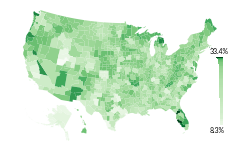

In [243]:
# Draw map
fig = plt.figure(figsize=(5.0,2.5))

m.drawmapboundary()
m.readshapefile(acsdir + 'shapefiles/cz1990', 'cz', drawbounds=False)

ax = plt.gca()

for info, shape in zip(m.cz_info, m.cz):
    fc = cmap(norm(d[info['cz']]['Age 0-17']))
    fc2 = cmap2(norm2(d[info['cz']]['Age 65+']))
    fc3 = cmap3(norm3(d[info['cz']]['NILF']))
    if info['cz'] in hi_cz:
        shape = [[x + 5200000, y - 1400000] for x, y in shape]
    elif info['cz'] in ak_cz:
        shape = [(x * 0.34 + 1280000, 
                  y * 0.34 - 1300000) for x, y in shape]
    #ax.add_patch(Polygon(shape, fc=fc))
    ax.add_patch(Polygon(shape, fc=fc2))
    #ax.add_patch(Polygon(shape, fc=fc3))

ax.axis('off')    

ax_inset = inset_axes(ax, width='-10%', height='50%', loc=4, borderpad=1.8) 
for i, pt in enumerate(pct2):
    rect = Rectangle(xy=(pt, i / 100), width=-pt, height=0.1, 
                     fc=cmap2(norm2(pt)), ec=None)
    ax_inset.add_patch(rect)    

ax_inset.text(0.6, 1.05, max_val2, fontsize=7)
ax_inset.text(0.6, -0.12, min_val2, fontsize=7)
ax_inset.axis('off')
plt.savefig(data_dir / 'over64pop.pgf', bbox_inches='tight')

In [ ]:
variables = {'DP05_0024E': 'Age 65+',
             'DP05_0019E': 'Age 0-17',
             'DP03_0114E': 'Other NILF',
             'DP05_0001E': 'Total'}
srs = ','.join(variables.keys())
area = 'for=public%20use%20microdata%20area:*'
base = 'https://api.census.gov/data/2018/acs/acs1/profile'
url = f'{base}?get={srs}&{area}&key={census_key}'
r = requests.get(url)

In [5]:
url = f'https://api.census.gov/data/timeseries/eits/resconst?get=geo_level_code,data_type_code,time_slot_id,seasonally_adj,category_code,cell_value,error_data&time=2012&key={census_key}'

In [6]:
r = requests.get(url)

In [7]:
r.json()

[['geo_level_code',
  'data_type_code',
  'time_slot_id',
  'seasonally_adj',
  'category_code',
  'cell_value',
  'error_data',
  'time'],
 ['MW', 'SINGLE', '745', 'yes', 'ACOMPLETIONS', '67', 'no', '2012-01'],
 ['MW', 'TOTAL', '745', 'yes', 'ACOMPLETIONS', '90', 'no', '2012-01'],
 ['MW', 'E_SINGLE', '745', 'yes', 'ACOMPLETIONS', '13', 'yes', '2012-01'],
 ['MW', 'E_TOTAL', '745', 'yes', 'ACOMPLETIONS', '13', 'yes', '2012-01'],
 ['MW', 'SINGLE', '745', 'yes', 'APERMITS', '75', 'no', '2012-01'],
 ['MW', 'TOTAL', '745', 'yes', 'APERMITS', '109', 'no', '2012-01'],
 ['MW', 'SINGLE', '745', 'yes', 'ASTARTS', '86', 'no', '2012-01'],
 ['MW', 'TOTAL', '745', 'yes', 'ASTARTS', '109', 'no', '2012-01'],
 ['MW', 'E_SINGLE', '745', 'yes', 'ASTARTS', '12', 'yes', '2012-01'],
 ['MW', 'E_TOTAL', '745', 'yes', 'ASTARTS', '12', 'yes', '2012-01'],
 ['MW', 'TOTAL', '745', 'no', 'AUTHNOTSTD', '5.6', 'no', '2012-01'],
 ['MW', 'SINGLE', '745', 'no', 'AUTHNOTSTD', '3.7', 'no', '2012-01'],
 ['MW', 'E_TOTAL', '